# CE-40957: Reinforcement Learning
## HW1

*Full name: Yalda Shabanzadeh*

*Student number: 98101822* 

In this notebook, you will learn about reinforcement learning and its implementation in OpenAI Gym environments. 


This notebook is intended to provide hands-on experience with implementing reinforcement learning algorithms and evaluating their performance. By working through the code and examples, you will gain a deeper understanding of how Q-learning and monte carlo method works and how it can be applied to real-world problems.

# 1. Q-learning

In [6]:
!pip install gym[toy_text]
!pip install imageio-ffmpeg
import gym
import glob
import time
import base64
import pickle
import imageio
import IPython
import numpy as np
from tqdm import trange, tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"
clear_output()

## Gym OpenAI Environments
`gym` is a library developed by OpenAI that provides a suite of environments for developing and comparing reinforcement learning algorithms. Each environment has a well-defined observation space and action space, as well as a reset function that returns the environment to its initial state.

The main steps involved in training an agent in a `gym` environment are:

1. Initialize the environment
2. Reset the environment to its initial state
3. Take an action in the current state
4. Observe the new state and reward
5. Update the agent's policy based on the observed reward and new state
6. Repeat steps 3 to 5 until the environment returns a "done" signal

Once the agent has learned a good policy, it can be evaluated by running it in the environment for several episodes and measuring its average reward.

### FrozenLake environment
The `FrozenLake-v1` environment is a variant of the classic reinforcement learning problem where the agent must navigate a grid while avoiding obstacles. 

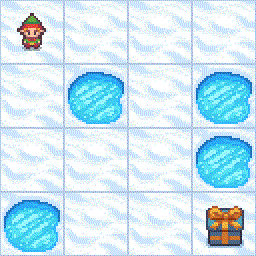


* **Observation Space:** The observation space of the environment is a grid representing the state of the lake.
* **Action Space:** The agent has four possible actions at each time step: move up, move down, move left, or move right.
* **Goal:** The goal of the agent is to reach the goal state while avoiding holes in the ice.
* **Reward:** Reach goal(G): +1 , Reach hole(H): 0 , Reach frozen(F): 0
* **Episode Termination:** The environment signals the end of an episode with a "done" signal.


In [7]:
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4")
spec = gym.spec('FrozenLake-v1')

print(f"Action Space: {env.action_space}")
print(f"Observation Space: {env.observation_space}")
print(f"Max Episode Steps: {spec.max_episode_steps}")
print(f"Nondeterministic: {spec.nondeterministic}")
print(f"Reward Range: {env.reward_range}")
print(f"Reward Threshold: {spec.reward_threshold}\n")

Action Space: Discrete(4)
Observation Space: Discrete(16)
Max Episode Steps: 100
Nondeterministic: False
Reward Range: (0, 1)
Reward Threshold: 0.7



In [8]:
Actions =  {0: 'LEFT', 
            1: 'DOWN',
            2: 'RIGHT',
            3: 'UP'}

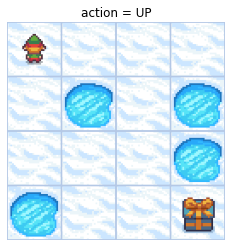

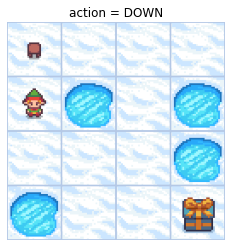

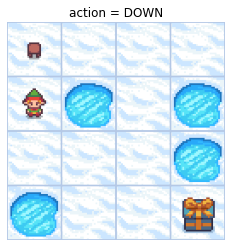

UP --> DOWN --> DOWN


In [15]:
# Be free to test!
# take random actions, and see how the agent moves

env.reset()

action_seq = []

for i in range(3):
    action_number = env.action_space.sample()
    action_seq.append(Actions[action_number])
    env.step(action_number)
    env_screen = env.render(mode='rgb_array')
    plt.imshow(env_screen)
    plt.title(f'action = {Actions[action_number]}')
    plt.axis('off')
    plt.show()

print(' --> '.join(action_seq))

In [80]:
# some general functions

def choose_action(Q, state, epsilon):
    """
    return chosen action based on epsilon-greedy algorithm
    """
    action = 0
    if np.random.uniform(0, 1) < epsilon:
        action = env.action_space.sample()
    else:
        action = np.argmax(Q[state, :])
    return action


def test(env, Q):
    """
    test the Q table
    """
    state = env.reset()
    for t in range(spec.max_episode_steps):
        action = np.argmax(Q[state, :])
        next_state, reward, done, info = env.step(action)
        if done:
            return reward, t
        else:
            state = next_state
    return 0.0, t # over limit


def get_seq_of_actions(env, Q):
    """
    get a sequence of actions with screens
    """
    state = env.reset()
    seq_of_actions = list()
    screens = list()
    succeed = False

    if not os.path.exists('img'):
        os.mkdir('img')

    for t in range(spec.max_episode_steps):
        action = np.argmax(Q[state, :])
        next_state, reward, done, _ = env.step(action)
        seq_of_actions.append(action)
        env_screen = env.render(mode='rgb_array')
        plt.imshow(env_screen)
        plt.axis('off')
        plt.title(f'action = {Actions[action]}')
        file_path = f'./img/img_{t}.png'
        plt.savefig(file_path)
        plt.close()
        image = imageio.imread(file_path)
        os.remove(file_path)
        screens.append(image)
        if done:
            if reward == 1:
                succeed = True
            break
        else:
            state = next_state

    return succeed, seq_of_actions, screens

def embed_mp4(filename):
    video = open(filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())
    
    return IPython.display.HTML(tag)


def save_mp4(filename, screens, fps=3):
    writer = imageio.get_writer(filename, fps=fps)
    for screen in screens:
        writer.append_data(screen)
    writer.close()


def analyze(env, Q, test_count):
    reward_total = 0.0
    episode_len = 0
    succeed_episode_len = 0
    for _ in range(test_count):
        reward, t = test(env, Q)
        reward_total += reward
        episode_len += t
        succeed_episode_len += t if reward != 0 else 0

    return reward_total, episode_len, succeed_episode_len


def print_analyze(reward_total, episode_len, succeed_episode_len, test_count):
    print("episodes      : {}".format(test_count))
    print("total reward  : {}".format(reward_total))
    print("average reward: {:.2f}".format(reward_total / test_count))
    print("average episode len: {:.2f}".format(episode_len / test_count))
    print("average succeed episode len: {:.2f}".format(succeed_episode_len / reward_total))

## Q-Learning
Q-Learning is a model-free reinforcement learning algorithm that is used to find the optimal policy for an agent in an environment. It is based on the idea of updating an estimate of the optimal action-value function using the Bellman equation. The optimal action-value function is defined as the maximum expected reward that an agent can receive by taking an action a in a state s and following the optimal policy thereafter.

The action-value function Q(s,a) is updated iteratively as follows:

$$ Q(s,a) \leftarrow Q(s,a) + \alpha \left( r + \gamma \max_{a'} Q(s',a') - Q(s,a) \right) $$

where ‍‍‍‍‍`r` is the reward received after taking action a in state `s`, `s'` is the new state, $\gamma$ is the discount factor (a value between 0 and 1 that determines the importance of future rewards), and $\alpha$ is the learning rate (determines the step size at which the value function is updated).

In [17]:
def q_learn(Q, state, action, reward, next_state, **kwargs):
    """
    updates Q base on Q-learning algorithm
    """
    alpha = kwargs['alpha']
    gamma = kwargs['gamma']
    predict = Q[state, action]
    target = reward + gamma * np.max(Q[next_state, :])
    Q[state, action] = Q[state, action] + alpha * (target - predict)


def q_learning(env, num_episodes, **kwargs):
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    
    for episode in tqdm(range(num_episodes)):
        state = env.reset()
        # ==================================== Your Code (Begin) ====================================
        for t in range(spec.max_episode_steps):
            action = choose_action(Q, state, kwargs['epsilon'])
            next_state, reward, done, info = env.step(action)
            q_learn(Q, state, action, reward, next_state, **kwargs)
            state = next_state

            if done:
                break
        # ==================================== Your Code (End) ====================================
    return Q

In [25]:
# change the parameters if needed
q_num_episodes = 10000
q_test_count = 1000
q_alpha = 0.05
q_gamma = 0.95
q_epsilon = 0.9

In [28]:
ql_kwargs = dict(alpha=q_alpha, gamma=q_gamma, epsilon=q_epsilon)
Q = q_learning(env, q_num_episodes, **ql_kwargs)
print(Q)

100%|██████████| 10000/10000 [00:04<00:00, 2069.97it/s]

[[0.18169237 0.17875679 0.17805495 0.17199094]
 [0.13034183 0.1085748  0.11468698 0.17143499]
 [0.17886144 0.15951947 0.15942393 0.15208268]
 [0.08995374 0.09783367 0.08756533 0.13695029]
 [0.20712891 0.13630133 0.14740289 0.12548882]
 [0.         0.         0.         0.        ]
 [0.19519657 0.06430985 0.19762801 0.03788458]
 [0.         0.         0.         0.        ]
 [0.17274539 0.19655615 0.18120364 0.2585573 ]
 [0.18977036 0.39126732 0.29924152 0.22866511]
 [0.40449598 0.37497854 0.25113868 0.16423694]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.2686892  0.4151927  0.50497191 0.34379906]
 [0.49672903 0.68182322 0.66062996 0.57455417]
 [0.         0.         0.         0.        ]]


In [33]:
with open(f'ql_Q_e_{q_epsilon}_alpha_{q_alpha}_gamma_{q_gamma}.pkl', 'wb') as f:
    pickle.dump(Q, f)

In [81]:
q_reward_total, q_episode_len, q_succeed_episode_len = analyze(env, Q, q_test_count)
print_analyze(q_reward_total, q_episode_len, q_succeed_episode_len, q_test_count)

episodes      : 1000
total reward  : 736.0
average reward: 0.74
average episode len: 39.62
average succeed episode len: 35.93


In [37]:
# Print sequence of actions that has taken to reach the goal
# Any visualization for further intuition would be appreciated.
succeed, seq_of_actions, screens = get_seq_of_actions(env, Q)

if succeed:
    print("Sequence of actions that reaches the goal:")
    print('->'.join(list(map(Actions.get, seq_of_actions))))
else:
    print('Failed!')

Sequence of actions that reaches the goal:
LEFT->LEFT->LEFT->LEFT->UP->UP->LEFT->UP->DOWN->LEFT->DOWN->RIGHT->DOWN->RIGHT->DOWN


In [38]:
# save screens as mp4

filename = f'./ql_e_{q_epsilon}_alpha_{q_alpha}_gamma_{q_gamma}.mp4'
save_mp4(filename, screens, fps=3)

In [39]:
embed_mp4(filename)

## SARSA
SARSA (State-Action-Reward-State-Action) is a popular reinforcement learning algorithm used for finding an optimal policy in an environment. Like Q-learning, SARSA is an off-policy algorithm that updates the values of the Q-table based on the observed rewards and next state-action pairs.

The key difference between SARSA and Q-learning is in the selection of the next action. In SARSA, the next action is selected based on the current policy, whereas in Q-learning, the next action is selected based on the greedy policy. This means that in SARSA, the algorithm is learning about the expected returns from the current policy, whereas in Q-learning, the algorithm is learning about the optimal policy.

Mathematically, the SARSA update rule can be represented as:

$$Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \alpha \left( R_{t+1} + \gamma Q(S_{t+1},A_{t+1}) - Q(S_t,A_t) \right)$$


Where $Q(S_t,A_t)$ is the current estimate of the expected return for taking action $A_t$ in state $S_t$, $\alpha$ is the learning rate, $R_{t+1}$ is the reward received after taking action $A_t$ in state $S_t$, $\gamma$ is the discount factor, and $Q(S_{t+1},A_{t+1})$ is the estimated return for taking action $A_{t+1}$ in the next state $S_{t+1}$.


In [40]:
def sarsa_learn(Q, state, action, reward, next_state, next_action, **kwargs):
    """
    updates Q base on SARSA algorithm
    """
    alpha = kwargs['alpha']
    gamma = kwargs['gamma']
    delta = Q[next_state, next_action] - Q[state, action]
    Q[state, action] += alpha * (reward + gamma * delta)


def sarsa(env, num_episodes, **kwargs):
    Q = np.zeros((env.observation_space.n, env.action_space.n))

    for episode in tqdm(range(num_episodes)):
        # ==================================== Your Code (Begin) ====================================
        state = env.reset()
        action = choose_action(Q, state, kwargs['epsilon'])
        for t in range(spec.max_episode_steps):
            next_state, reward, done, info = env.step(action)
            next_action = choose_action(Q, next_state, kwargs['epsilon'])
            sarsa_learn(Q, state, action, reward, next_state, next_action, **kwargs)
            state = next_state
            action = next_action

            if done:
                break
        # ==================================== Your Code (End) ====================================
    return Q

In [69]:
# change the parameters if needed
s_num_episodes = 10000
s_test_count = 1000
s_alpha = 0.05
s_gamma = 0.95
s_epsilon = 0.5

In [70]:
sarsa_kwargs = dict(alpha=s_alpha, gamma=s_gamma, epsilon=s_epsilon)
sarsa_Q = sarsa(env, s_num_episodes, **sarsa_kwargs)
print(sarsa_Q)

100%|██████████| 10000/10000 [00:05<00:00, 1889.54it/s]

[[0.07450057 0.07373465 0.069401   0.06856623]
 [0.04916637 0.05058609 0.04321995 0.06841404]
 [0.07890729 0.06212632 0.06725692 0.06475585]
 [0.0473526  0.04492604 0.03216132 0.05874944]
 [0.09494291 0.07530993 0.07407176 0.06213533]
 [0.         0.         0.         0.        ]
 [0.09432411 0.08201134 0.10570801 0.01967734]
 [0.         0.         0.         0.        ]
 [0.06815439 0.09014795 0.08885106 0.12243147]
 [0.14892907 0.19924751 0.16710039 0.1274062 ]
 [0.32988413 0.21825039 0.23864307 0.09880875]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.12000645 0.32557046 0.33787326 0.28021747]
 [0.39659113 0.74281683 0.67998078 0.5081792 ]
 [0.         0.         0.         0.        ]]


In [74]:
# save sarsa Q table

with open(f'sarsa_Q_e_{s_epsilon}_alpha_{s_alpha}_gamma_{s_gamma}.pkl', 'wb') as f:
    pickle.dump(sarsa_Q, f)

In [84]:
s_reward_total, s_episode_len, s_succeed_episode_len = analyze(env, sarsa_Q, s_test_count)
print_analyze(s_reward_total, s_episode_len, s_succeed_episode_len, s_test_count)

episodes      : 1000
total reward  : 707.0
average reward: 0.71
average episode len: 40.98
average succeed episode len: 37.24


In [73]:
# Print sequence of actions that has taken to reach the goal
# Any visualization for further intuition would be appreciated.
succeed, seq_of_actions, screens = get_seq_of_actions(env, sarsa_Q)

if succeed:
    print("Sequence of actions that reaches the goal:")
    print('->'.join(list(map(Actions.get, seq_of_actions))))
else:
    print('Failed!')

Sequence of actions that reaches the goal:
LEFT->LEFT->LEFT->LEFT->LEFT->LEFT->LEFT->LEFT->LEFT->LEFT->UP->UP->DOWN->LEFT->DOWN->DOWN


In [75]:
# save screens as mp4

filename = f'./sarsa_e_{s_epsilon}_alpha_{s_alpha}_gamma_{s_gamma}.mp4'
save_mp4(filename, screens, fps=3)

In [76]:
embed_mp4(filename)

## Conclution
Compare these 2 methods based on average return, penalty, episode length and success rate.
In the previous cells, if necessary, store the necessary variables for this comparison and use them in the following block.

In [85]:
print('Q-Learning')
print_analyze(q_reward_total, q_episode_len, q_succeed_episode_len, q_test_count)

Q-Learning
episodes      : 1000
total reward  : 736.0
average reward: 0.74
average episode len: 39.62
average succeed episode len: 35.93


In [86]:
print('SARSA')
print_analyze(s_reward_total, s_episode_len, s_succeed_episode_len, s_test_count)

SARSA
episodes      : 1000
total reward  : 707.0
average reward: 0.71
average episode len: 40.98
average succeed episode len: 37.24


> As we can see, `average reward` (which equals `success rate` and `average return`) is greater in Q-Learning than Sarsa.

> `penalty` is zero for both cases. (No need to calculate)

> `average episode lenght` and `average succeeded episode lenght` are both greater in SARSA than Q-Learning. (which means Q-Learning is better).

In stochastic environments, Q-learning is often considered to be better than SARSA due to its ability to handle the exploration-exploitation trade-off more effectively.

Q-learning is an off-policy learning algorithm, meaning that it learns the optimal policy regardless of the policy being followed. This allows Q-learning to explore the environment more thoroughly and potentially find a better policy. In contrast, SARSA is an on-policy learning algorithm, which means that it learns the value function for the policy being followed. This can lead to SARSA getting stuck in suboptimal policies if it doesn't explore the environment enough.

Furthermore, Q-learning is known to be more robust to noise and randomness in the environment. In stochastic environments, the agent may receive unexpected rewards or encounter unexpected states. Q-learning is less affected by such random events because it updates its Q-values based on the maximum expected reward from a given state, regardless of the actual reward received. In contrast, SARSA updates its Q-values based on the actual reward received, which can be noisy and unpredictable in a stochastic environment.

However, it's worth noting that the choice between Q-learning and SARSA ultimately depends on the specific characteristics of the environment and the problem being solved. In some cases, SARSA may be more appropriate, especially if the exploration-exploitation trade-off is less critical.

# 2. Monte Carlo method

In this notebook, you will learn about the Monte Carlo method in the context of reinforcement learning.
Your agent will move in the following picture. This is a random walk with two possible actions (`LEFT` and `RIGHT`).
The agent gets a reward of 1 if it reaches the right-most state, and 0 otherwise. You are going to use such an environment with 31 states.

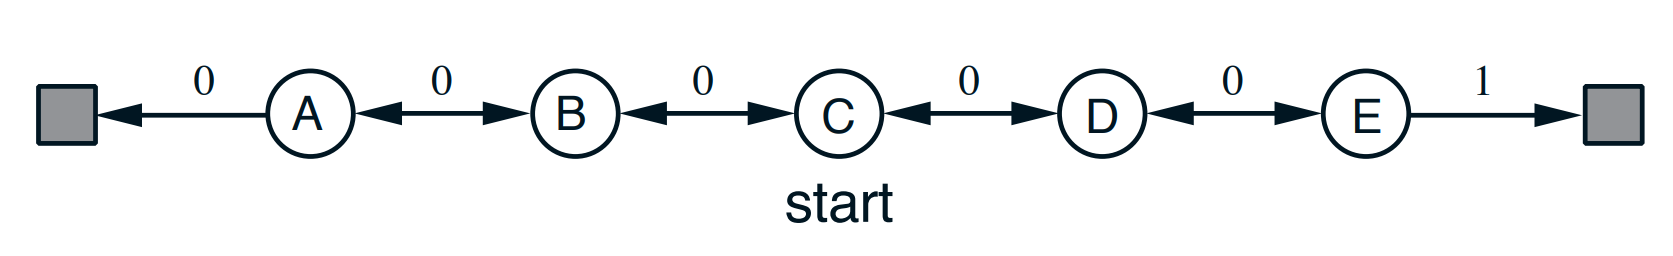

In [ ]:
class RandomWalkEnv():
    def __init__(self, num_states=31, start=15, gamma=1):
        self.num_states = num_states
        self.start = start
        self.end = num_states - 1
        self.gamma = gamma
        self.state = None
        self.actions = ['LEFT', 'RIGHT']

    def reset(self):
        self.state = self.start
        return self.state, 0, False

    def step(self, action):
        if self.state == self.end or self.state == 0:
            return self.state, 0, True
        action_direction = 0
        if action == 'RIGHT':
            action_direction = 1
        elif action == 'LEFT':
            action_direction = -1

        self.state += action_direction
        reward, done = 0, False
        if self.state == self.end:
            reward, done = 1, True
        elif self.state == 0:
            done = True
        return self.state, reward, done

    def get_true_values(self):
        values = [0] * self.num_states
  
        values[self.end - 1] = 1
        for i in range(self.end - 1, 1, -1):
            values[i - 1] = self.gamma * values[i]
        
        return values
    
    def sample(self):
        return np.random.choice(self.actions, 1)

The Monte Carlo method is a reinforcement learning technique for estimating the value function of a Markov decision process (MDP). It involves generating multiple episodes by following a given policy and computing the returns (sum of rewards) for each state-action pair. The value of a state-action pair is then estimated as the average of the returns obtained from that pair over multiple episodes.

The formula for updating the value function using the Monte Carlo method is:

\begin{equation}
Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \frac{1}{N(S_t,A_t)} \sum_{i=1}^{N(S_t,A_t)}(G_i - Q(S_t,A_t))
\end{equation}

where $Q(S_t,A_t)$ is the estimated value of the state-action pair $(S_t,A_t)$, $N(S_t,A_t)$ is the number of times the state-action pair has been visited, $G_i$ is the return obtained from the $i$th visit to the state-action pair, and the sum is taken over all $N(S_t,A_t)$ visits.

To implement the Monte Carlo method, you need to define the environment, the policy, and the number of episodes to simulate. At each step of the episode, you observe the state, take an action according to the policy, and observe the reward and the next state. You then update the value function using the formula above. As more episodes are generated, the value estimates become more accurate.

In [ ]:
def gen_episode(env, Q):
    """
    generate and episode and return its states & rewards
    """
    state, _, _ = env.reset()
    episode_rewards = list()
    episode_states = [state]
    episode_actions = list()
    while True:
        action = env.sample()
        next_state, reward, done = env.step(action)
        episode_rewards.append(reward)
        episode_states.append(next_state)
        episode_actions.append(action)
        if done:
            episode_states.pop()
            break
        state = next_state
    return episode_states, episode_rewards, episode_actions


def update_values(Q, alpha, episode_states, episode_rewards, episode_actions):
    """
    calculate G and update V
    """
    G = 0
    for t in range(len(episode_states) - 1, -1, -1):
        state = episode_states[t]
        reward = episode_rewards[t]
        action = episode_actions[t]
        G += reward
        action = 0 if action == 'LEFT' else 1 # left: 0 - right: 1
        if state not in episode_states[:t]:
            Q[state, action] += alpha * (G - Q[state, action])


def update_errors(errors, values, true_values):
    """
    calculate RMSE and update errors
    """
    error = np.sqrt(np.mean((values - true_values) ** 2))
    errors.append(error)


def MC(env, num_episodes, alpha=0.1):
    # ==================================== Your Code (Begin) ====================================
    Q = np.zeros((env.num_states, len(env.actions))) # just use to get values, not used in policy
    errors = list()
    true_values = env.get_true_values()

    for episode in range(num_episodes):
        states, rewards, actions = gen_episode(env, Q)
        update_values(Q, alpha, states, rewards, actions)
        values = np.max(Q, axis=1)
        update_errors(errors, values, true_values)
    
    values = np.max(Q, axis=1)
    # ==================================== Your Code (End) ====================================
    return values, errors, Q

------alpha = 0.01------


100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


------alpha = 0.02------


100%|██████████| 100/100 [01:25<00:00,  1.17it/s]


------alpha = 0.03------


100%|██████████| 100/100 [01:29<00:00,  1.12it/s]


------alpha = 0.04------


100%|██████████| 100/100 [01:24<00:00,  1.18it/s]


------alpha = 0.05------


100%|██████████| 100/100 [01:26<00:00,  1.16it/s]


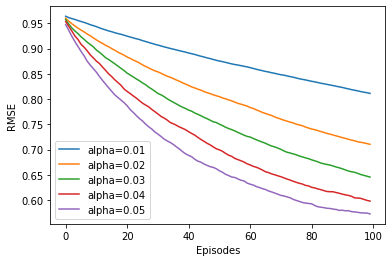

In [ ]:
# Visualization

import matplotlib.pyplot as plt


env = RandomWalkEnv()
num_episodes = 100
alphas = [0.01, 0.02, 0.03, 0.04, 0.05]
num_runs = 100
saved_Qs = dict()

for alpha in alphas:
    rmse_avg = np.zeros(num_episodes)
    print(f'------alpha = {alpha}------')
    for run in tqdm(range(num_runs)):
        values, errors, Q = MC(env, num_episodes, alpha)
        rmse_avg += np.array(errors)
        if run == num_runs - 1:
            saved_Qs[alpha] = Q
    rmse_avg /= num_runs
    plt.plot(range(num_episodes), rmse_avg, label=f'alpha={alpha}')
plt.legend()
plt.xlabel('Episodes')
plt.ylabel('RMSE')
plt.show()

# Any visualization for better intuition would be appreciated.

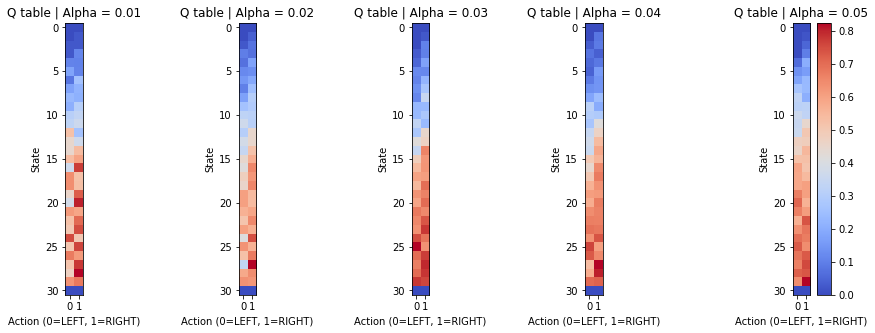

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


plt.rcParams['figure.figsize'] = (15, 5)
fig, axes = plt.subplots(nrows=1, ncols=5)

for i, (alpha, Q) in enumerate(saved_Qs.items()):
    ax = axes[i]
    im = ax.imshow(Q, cmap='coolwarm')
    if i == 4:
        plt.colorbar(im, ax=ax)
    ax.set_xlabel('Action (0=LEFT, 1=RIGHT)')
    ax.set_ylabel('State')
    ax.set_title(f'Q table | Alpha = {alpha}')

plt.show()

In Monte Carlo methods, alpha (also known as the learning rate) controls the extent to which the estimated value function is updated after each episode. A larger alpha means that the estimated value function is updated more aggressively, which can lead to faster convergence.

The reason for this is that a larger alpha places more weight on the most recent rewards when updating the estimated value function. In Monte Carlo methods, the estimated value of a state is updated at the end of each episode by taking the average of the returns observed from that state. When alpha is larger, this average is weighted more towards the most recent returns, which can help the estimated value function converge faster.

Another way to think about it is that a larger alpha can help the agent respond more quickly to changes in the environment. If the environment changes and the rewards associated with certain states change, a larger alpha can help the agent update its value function to reflect these changes more quickly.